<a href="https://colab.research.google.com/github/kandgesid/Data-Science-and-ML-projects/blob/master/image_caption(version_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
cd '/content/drive/My Drive/image_captioning_dataset'

/content/drive/My Drive/image_captioning_dataset


In [3]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from PIL import Image
import pickle

In [4]:
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [5]:
dataset_text = '/content/drive/My Drive/image_captioning_dataset/Flickr8k_text'
dataset_img = '/content/drive/My Drive/image_captioning_dataset/Flickr8k_Dataset'

In [6]:
def load_file(filename):
  reader = open(filename, 'r')
  data = reader.read()
  reader.close()
  return data

def all_image_cap(filename):
  data = load_file(filename)
  lines = data.split('\n')
  description = {}

  for line in data.split('\n'):
    tokens = line.split()
    if len(line) < 2:
      continue
    img_id, caption = tokens[0], tokens[1:]
    img_id = img_id.split('.')[0]
    caption = " ".join(caption)
    if img_id not in description:
      description[img_id] = [ caption ]
    else:
      description[img_id].append(caption)
  return description


In [7]:
filename = dataset_text + "/" + "Flickr8k.token.txt"

descriptions = all_image_cap(filename)
print('Length of description', len(descriptions))

Length of description 8092


In [8]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [9]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [10]:
def clean_descriptions(captions):
  table = str.maketrans('', '', string.punctuation)
  for img, cap_to_image in captions.items():
    for i, caption in enumerate(cap_to_image):
      caption.replace('-', ' ')
      words = caption.split()

      words = [word.lower() for word in words]

      words = [word.translate(table) for word in words]

      words = [word for word in words if len(word) > 1]

      words = [word for word in words if(word.isalpha())]

      caption = ' '.join(words)
      captions[img][i] = caption
  return captions

In [11]:
descriptions = clean_descriptions(descriptions)

In [12]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [12]:
def save_description(description, filename):
  lines = list()
  for key, captions in description.items():
    for caption in captions:
      lines.append(key + '\t' + caption)
    data = '\n'.join(lines)
    file = open(filename, "w")
    file.write(data)
    file.close()
  
save_description(descriptions, "description_final.txt")

In [13]:
def load_images(filename):
	doc = load_file(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_file(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = '<start> ' + ' '.join(image_desc) + ' <end>'
			# store
			descriptions[image_id].append(desc)
	return descriptions

In [14]:
filename = dataset_text + '/' + "Flickr_8k.trainImages.txt"

train = load_images(filename)
print(len(train))

6000


In [15]:
train_descriptions = load_clean_descriptions('description_final.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [ ]:
train_descriptions

In [18]:
images = []
import glob 
for img in glob.glob('/content/drive/My Drive/image_captioning_dataset/Flicker8k_Dataset/*'):
  images.append(img)
len(images)

14091

In [19]:
images[0]

'/content/drive/My Drive/image_captioning_dataset/Flicker8k_Dataset/489372715_ce52da796a.jpg.npy'

In [20]:
train_images_file = dataset_text + '/' + "Flickr_8k.trainImages.txt"
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = [] 
for i in images: # img is list of full path names of all images
  if i[len('/content/drive/My Drive/image_captioning_dataset/Flicker8k_Dataset/'):] in train_images: # Check if the image belongs to training set
    train_img.append(i) # Add it to the list of train images

In [ ]:
print(train_img)

In [22]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [23]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


In [22]:
encode_train = sorted(set(train_img))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [24]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [25]:
len(train_img)

6000

In [26]:
import random
random.seed(10)
train_cap = []
for i in train_img:
  image_id = i[len('/content/drive/My Drive/image_captioning_dataset/Flicker8k_Dataset/'):-4]
  all_cap = train_descriptions[image_id]
  #print(len(all_cap))
  #[train_cap.append(cap) for cap in all_cap]
  cap = random.choice(all_cap)
  train_cap.append(cap)

In [27]:
len(train_cap)

6000

In [28]:
#top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_cap)
train_seqs = tokenizer.texts_to_sequences(train_cap)

In [29]:
len(tokenizer.word_index)

3818

In [30]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [31]:
train_seqs = tokenizer.texts_to_sequences(train_cap)

In [32]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [33]:
max_length = calc_max_length(train_seqs)
max_length

34

In [34]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 100
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(train_img) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [35]:
cap_vector.shape

(6000, 34)

In [36]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [37]:
dataset = tf.data.Dataset.from_tensor_slices((train_img, cap_vector))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [39]:
len(tokenizer.word_index.items())

3819

In [38]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [39]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [40]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


In [41]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [42]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  #print(type(loss_))
  return tf.reduce_mean(loss_)

In [43]:
checkpoint_path = "./checkpointsfinal/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [44]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [45]:
loss_plot = []
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [46]:
EPOCHS = 20
import time
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 4 Batch 0 Loss 0.7925
Epoch 4 Loss 0.763029
Time taken for 1 epoch 1943.2074086666107 sec

Epoch 5 Batch 0 Loss 0.7408
Epoch 5 Loss 0.720279
Time taken for 1 epoch 247.10341119766235 sec

Epoch 6 Batch 0 Loss 0.7339
Epoch 6 Loss 0.678123
Time taken for 1 epoch 236.81054711341858 sec

Epoch 7 Batch 0 Loss 0.6937
Epoch 7 Loss 0.641101
Time taken for 1 epoch 237.07171630859375 sec

Epoch 8 Batch 0 Loss 0.5622
Epoch 8 Loss 0.600160
Time taken for 1 epoch 236.63245558738708 sec

Epoch 9 Batch 0 Loss 0.5009
Epoch 9 Loss 0.565935
Time taken for 1 epoch 236.10128545761108 sec

Epoch 10 Batch 0 Loss 0.5747
Epoch 10 Loss 0.528818
Time taken for 1 epoch 236.47703981399536 sec

Epoch 11 Batch 0 Loss 0.4958
Epoch 11 Loss 0.494297
Time taken for 1 epoch 238.52849078178406 sec

Epoch 12 Batch 0 Loss 0.4318
Epoch 12 Loss 0.463839
Time taken for 1 epoch 237.33408570289612 sec

Epoch 13 Batch 0 Loss 0.4311
Epoch 13 Loss 0.433916
Time taken for 1 epoch 237.11172366142273 sec

Epoch 14 Batch 0 Loss 

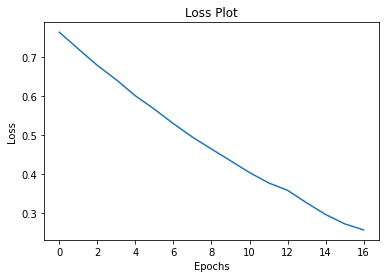

In [47]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [48]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


In [49]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Prediction Caption: blond child with her are looking in her colored are looking among the little girl are wearing green colored are resting on the camera with her are resting in pink is looking at her


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  


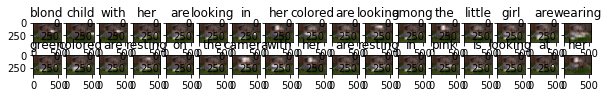

In [50]:
image = '/content/image-caption-generator-girls-playing (2).png'
#real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

#print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Prediction Caption: man wearing green shirt does trick on surfboard riding down <end>


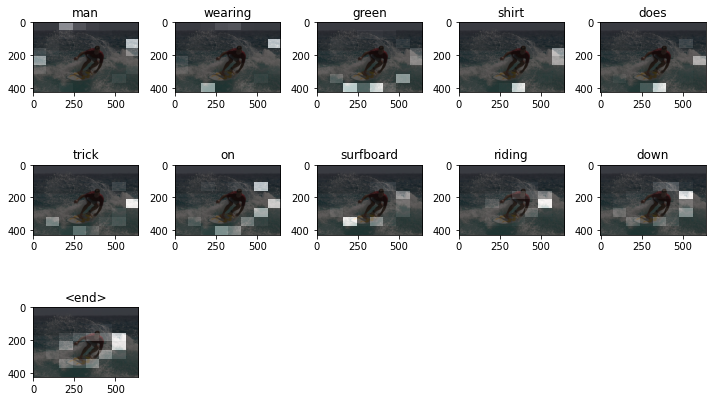

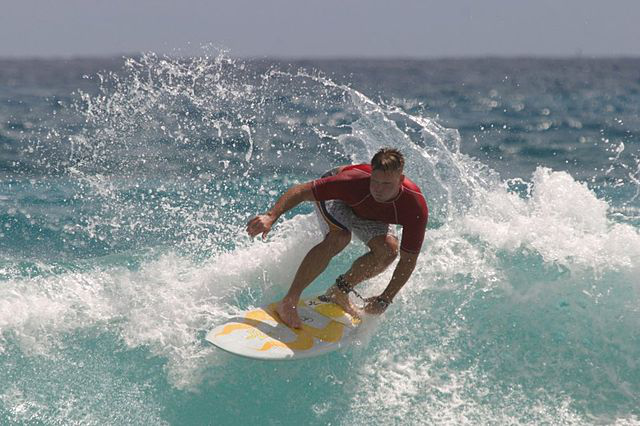

In [52]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)